# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, roc_auc_score

# Models
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [2]:
np.random.seed(100)
random.seed(100)

# Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root_dir = "/content/drive/MyDrive/pattern_recognition_lab/"

# Checking if our specified directory exists
os.path.exists(root_dir)

# Load the dataset using pandas
df = pd.read_csv(os.path.join(root_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(root_dir, "test.csv"))
id_of_test = df_test['id']

df.head()

,id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,12224,46,admin.,married,high.school,unknown,no,no,telephone,jul,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
1,36387,32,admin.,married,university.degree,no,yes,yes,cellular,jun,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,yes
2,22703,36,technician,single,university.degree,no,no,no,cellular,aug,...,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
3,32742,30,services,single,high.school,no,yes,yes,cellular,may,...,1,999,2,failure,-1.8,92.893,-46.2,1.299,5099.1,no
4,40547,76,retired,divorced,basic.4y,no,no,no,cellular,aug,...,1,999,1,failure,-1.7,94.027,-38.3,0.886,4991.6,yes


# 1. Data Exploaration

##1-1. Descriptive Statistics

In [5]:
df.describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='Blues')\
                     .bar(subset=["max"], color='#FF8E99')\
                     .bar(subset=["mean",], color='pink')

,count,mean,std,min,25%,50%,75%,max
id,32950.000000,20569.615569,11895.520420,1.000000,10258.250000,20571.000000,30846.750000,41188.000000
pdays,32950.000000,962.415964,187.054556,0.000000,999.000000,999.000000,999.000000,999.000000
nr.employed,32950.000000,5167.036495,72.250873,4963.600000,5099.100000,5191.000000,5228.100000,5228.100000
age,32950.000000,40.023703,10.401749,17.000000,32.000000,38.000000,47.000000,98.000000
cons.conf.idx,32950.000000,-40.500091,4.632363,-50.800000,-42.700000,-41.800000,-36.400000,-26.900000
campaign,32950.000000,2.567830,2.766994,1.000000,1.000000,2.000000,3.000000,56.000000
euribor3m,32950.000000,3.622516,1.734791,0.634000,1.344000,4.857000,4.961000,5.045000
emp.var.rate,32950.000000,0.083129,1.571951,-3.400000,-1.800000,1.100000,1.400000,1.400000
cons.price.idx,32950.000000,93.576610,0.578725,92.201000,93.075000,93.749000,93.994000,94.767000
previous,32950.000000,0.172838,0.498098,0.000000,0.000000,0.000000,0.000000,7.000000


## 1-2. Data Visualization

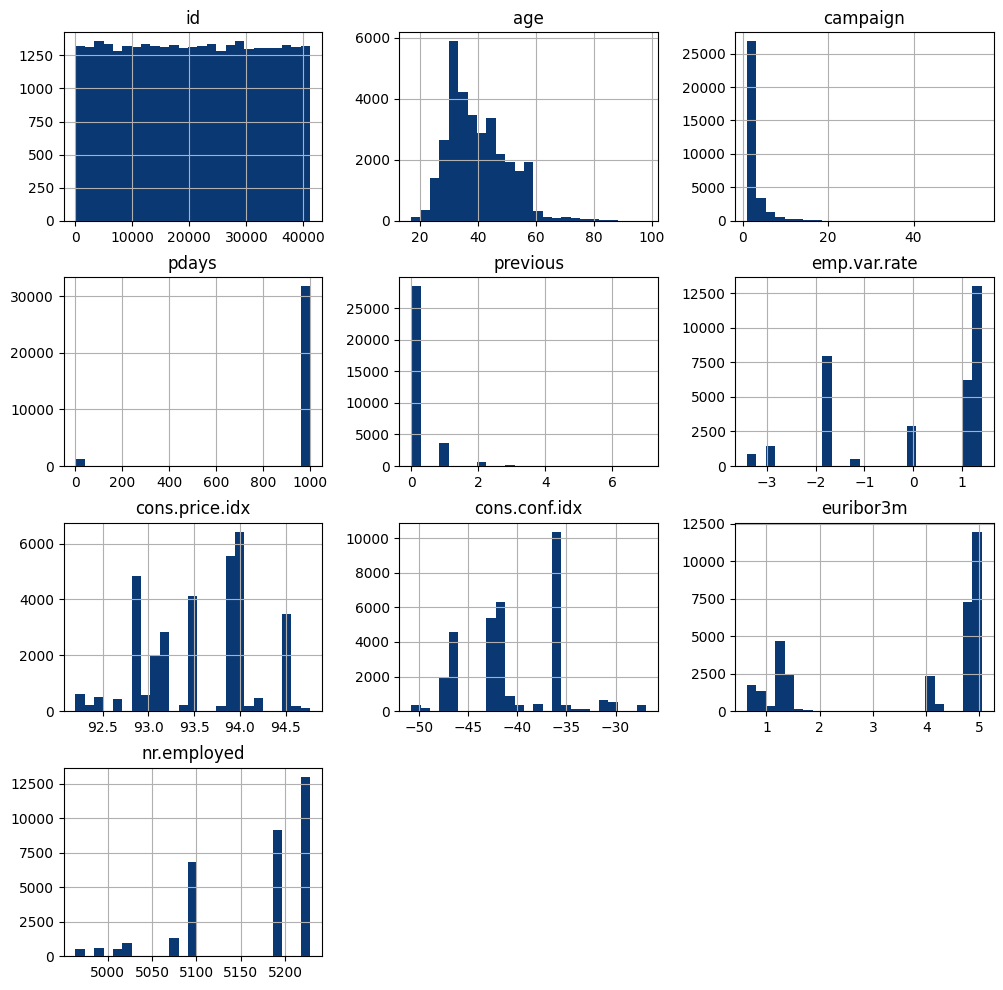

In [6]:
# plot histogram of numerical variables
df.hist(bins = 25, figsize = (12, 12), color='#0A3873')
plt.show()

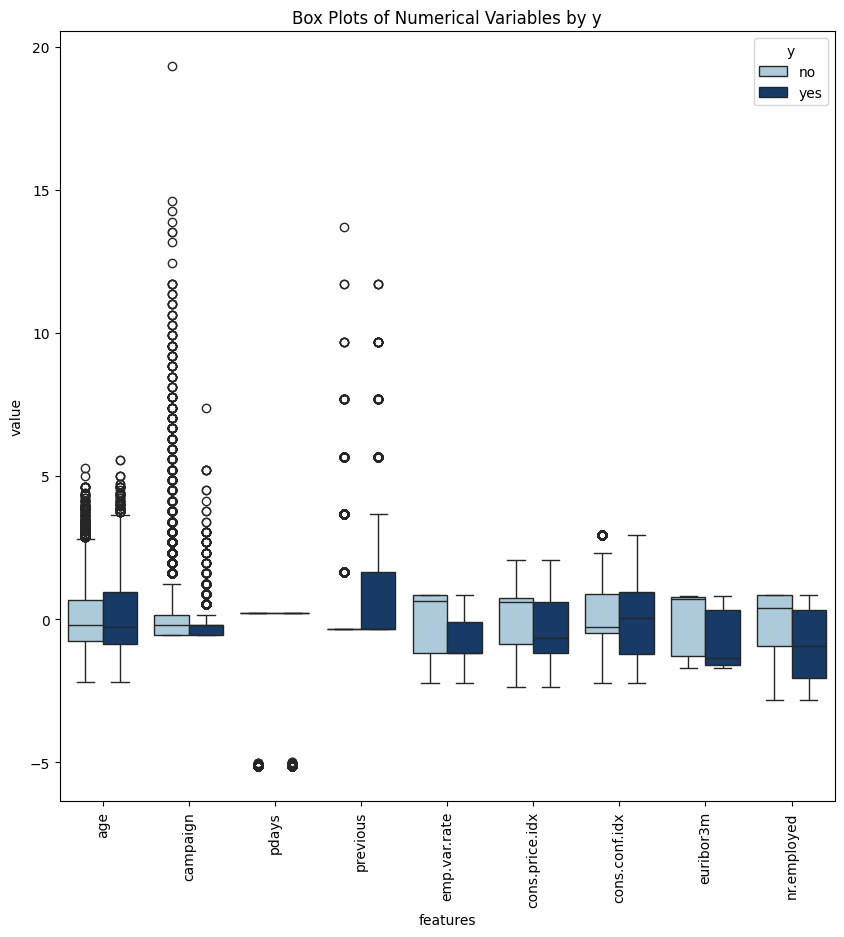

In [7]:
num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data = df[num]
y = df['y']

data_2 = (data - data.mean()) / (data.std()) # standardization
data = pd.concat([y,data_2.iloc[:,0:10]],axis=1)

df_melted = pd.melt(data, id_vars='y', value_vars=num,
                    var_name='features', value_name='value')

# draw box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='features', y='value', hue='y', data=df_melted, palette={'yes': '#0A3873', 'no': '#A4CDE2'})
plt.xticks(rotation=90)
plt.title('Box Plots of Numerical Variables by y')
plt.show()

<Axes: >

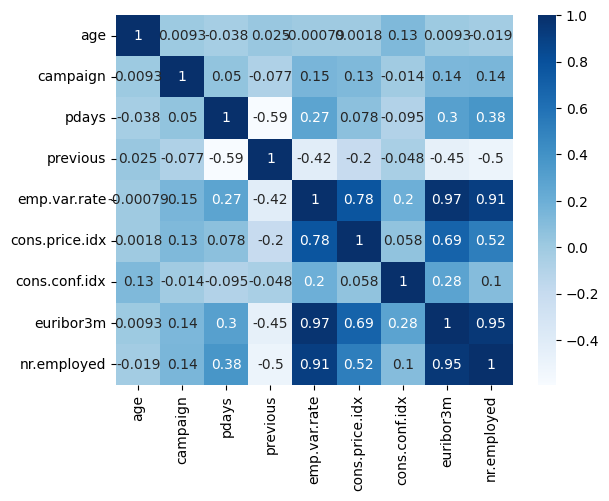

In [8]:
sns.heatmap(df[num].corr(),annot=True,cmap="Blues")

<Axes: >

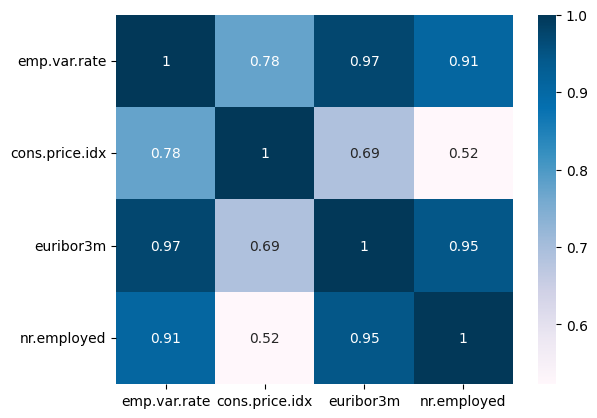

In [9]:
se = ['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
sns.heatmap(df[se].corr(),annot=True,cmap="PuBu")

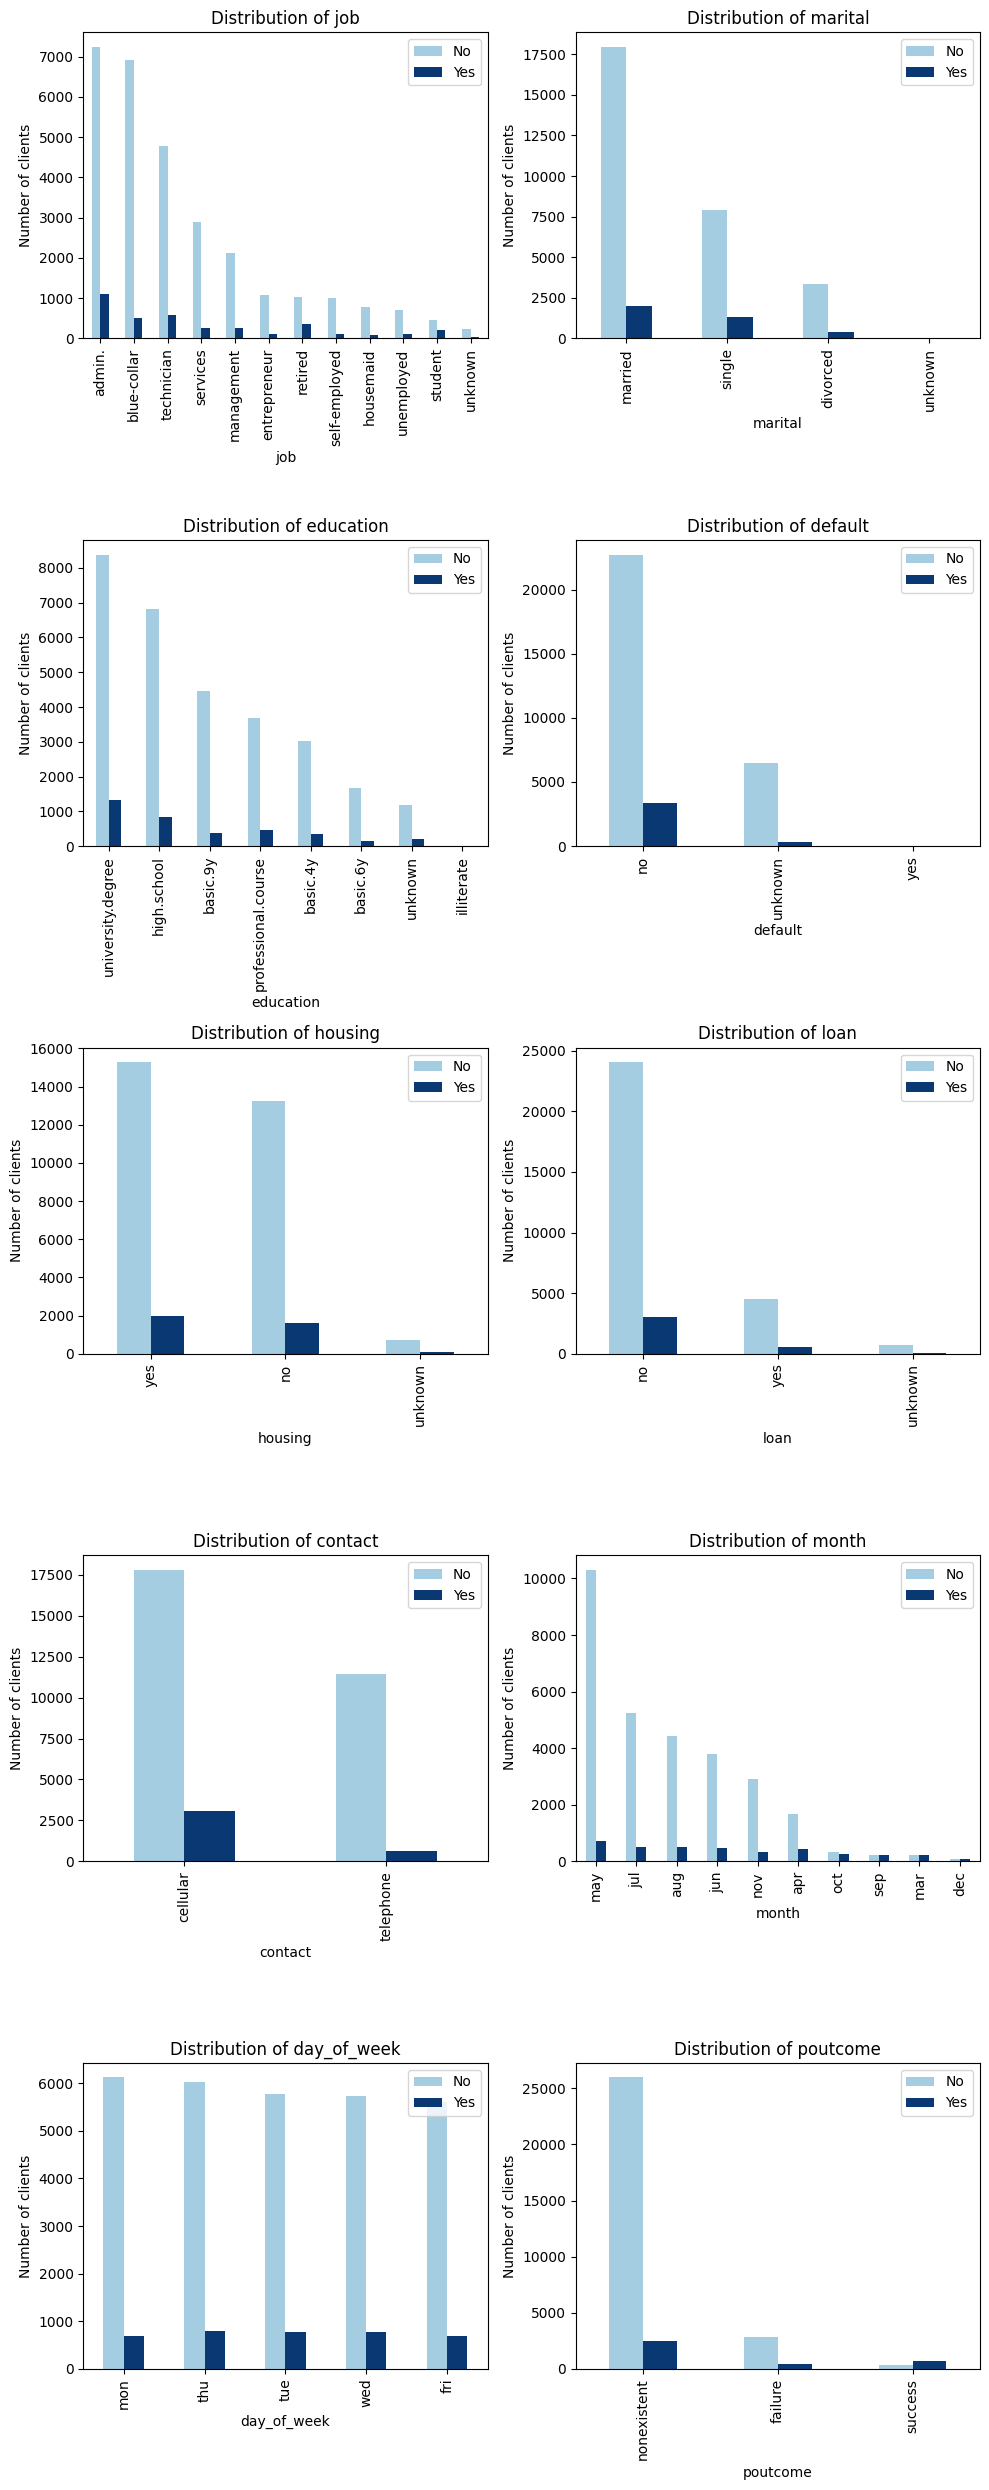

In [10]:
def plot_bar(column, ax):
    temp_1 = pd.DataFrame()
    temp_1['No'] = df[df['y'] == 'no'][column].value_counts()
    temp_1['Yes'] = df[df['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar', ax=ax, color=['#A4CDE2', '#0A3873'])
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Number of clients')
    ax.set_title(f'Distribution of {column}')

cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

n_cols = 2
n_rows = (len(cat) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

for ax, column in zip(axs.flatten(), cat):
    plot_bar(column, ax)

for i in range(len(cat), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

#2. Data preprocessing

In [11]:
# Change missing values 'unknown' and 'nonexistent' to NaN
df.replace('unknown', np.nan, inplace=True)
df.replace('nonexistent', np.nan, inplace=True)

df_test.replace('unknown', np.nan, inplace=True)
df_test.replace('nonexistent', np.nan, inplace=True)

In [12]:
# There are missing values in the data, and handling these missing values is necessary.
print('Train set Missing Values:')
print(df.isna().sum())
print('')
print('Test set Missing Values:')
print(df_test.isna().sum())

Train set Missing Values:
id                    0
age                   0
job                 257
marital              62
education          1388
default            6853
housing             799
loan                799
contact               0
month                 0
day_of_week           0
campaign              0
pdays                 0
previous              0
poutcome          28474
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

Test set Missing Values:
id                   0
age                  0
job                 73
marital             18
education          343
default           1744
housing            191
loan               191
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome          7089
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m        

##2-1. Feature Selection

In [13]:
drop_vars = ['id','default',"contact",'day_of_week','pdays','emp.var.rate','cons.conf.idx']

df.drop(drop_vars, axis=1, inplace=True)
test_id = df_test['id']
df_test.drop(drop_vars, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32693 non-null  object 
 2   marital         32888 non-null  object 
 3   education       31562 non-null  object 
 4   housing         32151 non-null  object 
 5   loan            32151 non-null  object 
 6   month           32950 non-null  object 
 7   campaign        32950 non-null  int64  
 8   previous        32950 non-null  int64  
 9   poutcome        4476 non-null   object 
 10  cons.price.idx  32950 non-null  float64
 11  euribor3m       32950 non-null  float64
 12  nr.employed     32950 non-null  float64
 13  y               32950 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 3.5+ MB


##2-2. Outliers

In [14]:
# train set
y_column = df['y']
df_no_y = df.drop(columns=['y'])

# Check the ratio of numerical outlier data for each numerical feature
numeric_features = df_no_y.select_dtypes(include=[np.number]).columns
outlier_ratios = {}
for feature in numeric_features:
    Q1 = df_no_y[feature].quantile(0.25)
    Q3 = df_no_y[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_no_y[(df_no_y[feature] < lower_bound) | (df_no_y[feature] > upper_bound)]
    outlier_ratio = len(outliers) / len(df_no_y)
    outlier_ratios[feature] = outlier_ratio
print("Outlier Ratios:", outlier_ratios)

# Replace outlier value with median
for feature in numeric_features:
    Q1 = df_no_y[feature].quantile(0.25)
    Q3 = df_no_y[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_val = df_no_y[feature].median()
    df_no_y.loc[(df_no_y[feature] < lower_bound) | (df_no_y[feature] > upper_bound), feature] = median_val

df_no_y['y'] = y_column
df = df_no_y

Outlier Ratios: {'age': 0.011532625189681336, 'campaign': 0.0582701062215478, 'previous': 0.1358421851289833, 'cons.price.idx': 0.0, 'euribor3m': 0.0, 'nr.employed': 0.0}


In [15]:
# test set
df_test_outlier = df_test.copy() # already wtihout y column

# Check the ratio of numerical outlier data for each numerical feature
numeric_features_test = df_test_outlier.select_dtypes(include=[np.number]).columns
outlier_ratios = {}
for feature in numeric_features_test:
    Q1 = df_test_outlier[feature].quantile(0.25)
    Q3 = df_test_outlier[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_test_outlier[(df_test_outlier[feature] < lower_bound) | (df_test_outlier[feature] > upper_bound)]
    outlier_ratio = len(outliers) / len(df_test_outlier)
    outlier_ratios[feature] = outlier_ratio
print("Outlier Ratios:", outlier_ratios)

# Replace outlier value with median
for feature in numeric_features_test:
    Q1 = df_test_outlier[feature].quantile(0.25)
    Q3 = df_test_outlier[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_val = df_test_outlier[feature].median()
    df_test_outlier.loc[(df_test_outlier[feature] < lower_bound) | (df_test_outlier[feature] > upper_bound), feature] = median_val

df_test = df_test_outlier

Outlier Ratios: {'age': 0.010803593105122602, 'campaign': 0.05899490167516387, 'previous': 0.13947560087399855, 'cons.price.idx': 0.0, 'euribor3m': 0.0, 'nr.employed': 0.0}


##2-2. Handling Missing Values
* Since all missing values are **categorical**, replace them with the *most frequent value* using **SimpleImputer**.

In [16]:
# train_set
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Except for each column for each column, label encoding application (in only variables)
for col in df_no_y.columns:
  # Apply label encoding only for categorical variables
    if df_no_y[col].dtype == 'object':
        col_no_na = df_no_y[col].dropna()
        encoder = LabelEncoder()
        df_no_y.loc[col_no_na.index, col] = encoder.fit_transform(col_no_na)

# Predict missing values using Iterative Imputter
imputer = IterativeImputer(max_iter=10, random_state=100, estimator=AdaBoostRegressor(random_state=100))
df_imputed = pd.DataFrame(imputer.fit_transform(df_no_y), columns=df_no_y.columns)


In [17]:
# test set
# Apply label encoding after exclusion of missing values for each column (categorical variables only)
for col in df_test.columns:
  # Apply label encoding only for categorical variables
    if df_test[col].dtype == 'object':
        col_no_na = df_test[col].dropna()
        encoder = LabelEncoder()
        df_test.loc[col_no_na.index, col] = encoder.fit_transform(col_no_na)

# Predict missing values using Iterative Imputter# IterativeImputer를 사용하여 결측치를 예측
imputer = IterativeImputer(max_iter=10, random_state=100, estimator=AdaBoostRegressor(random_state=100))
df_imputed_test = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)
df_imputed_test

,age,job,marital,education,housing,loan,month,campaign,previous,poutcome,cons.price.idx,euribor3m,nr.employed
0,54.0,0.0,1.0,6.0,0.0,0.0,7.0,1.0,0.0,0.217241,93.200,4.191,5195.8
1,36.0,2.0,1.0,6.0,1.0,1.0,4.0,1.0,0.0,0.255814,94.465,4.864,5228.1
2,27.0,10.0,1.0,3.0,1.0,0.0,6.0,4.0,0.0,0.172316,92.893,1.244,5099.1
3,39.0,0.0,1.0,6.0,1.0,0.0,1.0,4.0,0.0,0.255814,93.444,4.965,5228.1
4,43.0,7.0,1.0,3.0,1.0,0.0,4.0,2.0,0.0,0.217241,94.465,4.959,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,30.0,7.0,1.0,3.0,1.0,0.0,7.0,2.0,0.0,0.080670,93.200,4.076,5195.8
8234,47.0,0.0,1.0,3.0,1.0,0.0,6.0,2.0,0.0,0.217241,93.994,4.857,5191.0
8235,37.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.217241,94.465,4.967,5228.1
8236,47.0,7.0,1.0,3.0,1.0,0.0,6.0,1.0,0.0,0.217241,93.994,4.856,5191.0


- Mulitplelinearity

In [18]:
# train set
from sklearn.decomposition import PCA

# PCA for two high multicollinearity numerical features
pca_features = ['euribor3m', 'nr.employed']
pca = PCA(n_components=1)
df_imputed['PCA_feature'] = pca.fit_transform(df_imputed[pca_features])

# Remove the original two variables
df_imputed = df_imputed.drop(columns=pca_features)
df = df_imputed
df

,age,job,marital,education,housing,loan,month,campaign,previous,poutcome,cons.price.idx,y,PCA_feature
0,46.0,0.00000,1.0,3.0,0.0,0.0,3.0,3.0,0.0,0.043541,93.918,0.0,-61.078268
1,32.0,0.00000,1.0,6.0,1.0,1.0,4.0,1.0,0.0,0.613990,92.963,1.0,90.866669
2,36.0,9.00000,2.0,6.0,0.0,0.0,1.0,5.0,0.0,0.043541,93.444,0.0,-61.078223
3,30.0,7.00000,2.0,3.0,1.0,1.0,6.0,1.0,0.0,0.000000,92.893,0.0,67.971726
4,38.0,5.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,94.027,1.0,175.453418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,37.0,0.00000,1.0,6.0,1.0,0.0,7.0,1.0,0.0,1.000000,93.200,0.0,-28.771155
32946,56.0,3.24606,2.0,2.0,0.0,1.0,3.0,5.0,0.0,0.043541,93.918,0.0,-61.078177
32947,55.0,0.00000,1.0,3.0,1.0,0.0,3.0,3.0,0.0,0.043541,93.918,0.0,-61.078132
32948,34.0,7.00000,1.0,3.0,0.0,0.0,4.0,1.0,0.0,0.043541,94.465,0.0,-61.078087


In [19]:
# test set
from sklearn.decomposition import PCA

# PCA for two high multicollinearity numerical features
pca_features = ['euribor3m', 'nr.employed']
pca = PCA(n_components=1)
df_imputed_test['PCA_feature'] = pca.fit_transform(df_imputed_test[pca_features])

# Remove the original two variables
df_imputed_test = df_imputed_test.drop(columns=pca_features)
df_test = df_imputed_test
df_test

,age,job,marital,education,housing,loan,month,campaign,previous,poutcome,cons.price.idx,PCA_feature
0,54.0,0.0,1.0,6.0,0.0,0.0,7.0,1.0,0.0,0.217241,93.200,-28.772058
1,36.0,2.0,1.0,6.0,1.0,1.0,4.0,1.0,0.0,0.255814,94.465,-61.079015
2,27.0,10.0,1.0,3.0,1.0,0.0,6.0,4.0,0.0,0.172316,92.893,67.969889
3,39.0,0.0,1.0,6.0,1.0,0.0,1.0,4.0,0.0,0.255814,93.444,-61.081303
4,43.0,7.0,1.0,3.0,1.0,0.0,4.0,2.0,0.0,0.217241,94.465,-61.081167
...,...,...,...,...,...,...,...,...,...,...,...,...
8233,30.0,7.0,1.0,3.0,1.0,0.0,7.0,2.0,0.0,0.080670,93.200,-28.769453
8234,47.0,0.0,1.0,3.0,1.0,0.0,6.0,2.0,0.0,0.217241,93.994,-23.988381
8235,37.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.217241,94.465,-61.081349
8236,47.0,7.0,1.0,3.0,1.0,0.0,6.0,1.0,0.0,0.217241,93.994,-23.988358


#3. Modeling Strategies

- 1. data split

In [20]:
names = ['age', 'campaign', 'previous', 'cons.price.idx', 'PCA_feature']

In [21]:
# train set
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

random_state = 100
shuffle = True
test_size_ratio = 0.18 # Set the test set to 20%

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_ratio, random_state=random_state, shuffle=shuffle)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27019, 12) (5931, 12) (27019,) (5931,)


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Normalization for numerical data
scaler = MinMaxScaler()
X_train[names] = scaler.fit_transform(X_train[names])
X_test[names] = scaler.transform(X_test[names])

In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize on numerical data
scaler = StandardScaler()
X_train[names] = scaler.fit_transform(X_train[names])
X_test[names] = scaler.transform(X_test[names])

# Training


In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
scoring = "neg_mean_squared_error"

models = {}

Gradient Boosting

In [25]:
# GB - regressor
model = GradientBoostingRegressor(loss="squared_error",
                                  subsample=1.0,
                                  random_state=random_state)

# Define the hyperparameters and their possible values
param_grid = {
    "n_estimators": [25, 50],
    "max_depth": [3, 6],
    "learning_rate": [0.1]
}

grid_search = GridSearchCV(model, param_grid, cv=kf, scoring=scoring, refit=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best CV score: {:.6f}".format(grid_search.best_score_))

model_selected = grid_search.best_estimator_

y_pred = model_selected.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print('')
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best CV score: -0.017755

Accuracy: 0.9740347327600742
F1: 0.8800623052959501
Mean Squared Error: 0.025965267239925812


##4. Interpretation
- decide to select GradientBoostingRegressor


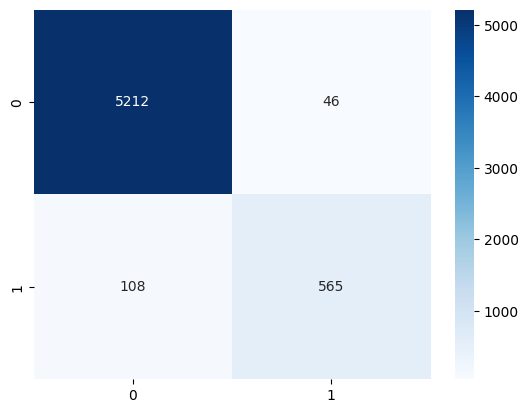

In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    columns=["Predicted Not-Subscribed", "Predicted Subscribed"],
    index=["Actual Not-Subscribed", "Actual Subscribed"]
)

sns.heatmap(conf_matrix,annot=True,fmt="d",cmap='Blues')
plt.show()

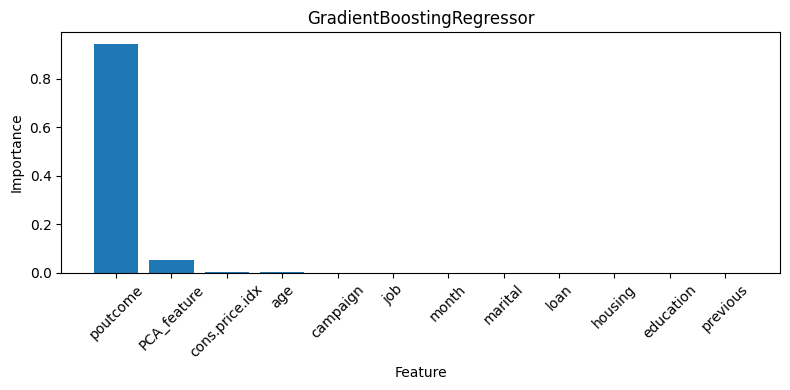

In [27]:

feature_importances = model_selected.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title("GradientBoostingRegressor")
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), X.columns[sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

#5. Predict 'y' column of test.csv

In [28]:
df_test_y_pred = model_selected.predict(df_test)
df_test_y_pred = (df_test_y_pred > 0.5).astype(int)

# Converting NumPy Array to Pandas Data Frame
df_test_y_pred = pd.DataFrame(df_test_y_pred, columns=['y_predict'])
df_test_y_pred

,y_predict
0,0
1,0
2,1
3,0
4,0
...,...
8233,0
8234,0
8235,0
8236,0


## 6. create prediction.csv
- combine 'id' column and prediction


In [29]:
# Converting a list or array of predicted values into a Pandas data frame
predictions_df = df_test_y_pred
# 2. Import the 'id' column of test data and combine it with the predicted value to form a single data frame
prediction = pd.concat([id_of_test, predictions_df], axis=1)
# Combining 'id' and predicted value into one data frame
# axis=1: Combined in column direction

prediction

,id,y_predict
0,24188,0
1,8688,0
2,35789,1
3,20034,0
4,11392,0
...,...,...
8233,26975,0
8234,6863,0
8235,9449,0
8236,916,0


In [30]:
# 3. Save results as CSV file
prediction.to_csv('prediction.csv', index=False)

In [31]:
from google.colab import files

# Download file
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>